## DL_Comp2_report   
team: SCLab  
C.S. Lin, P.Y. Yang, J.H. Tseng, Y.C Huang

## Data Augmentation

In [20]:
from math import trunc
from multiprocessing.sharedctypes import Value
import xml.etree.ElementTree as ET
import xml.dom.minidom
import os
from zoneinfo import available_timezones
import cv2
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

from data_aug.data_aug import *
from data_aug.bbox_util import *

import matplotlib.pyplot as plt 
import pickle as pkl
%matplotlib inline

NametoId = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}
data_folder_path = os.path.join('.', 'datalab-2021-cup2-object-detection')
train_annotation_path = os.path.join(data_folder_path, 'VOCdevkit_train', 'VOC2007', 'Annotations')
train_Image_path = os.path.join(data_folder_path, 'VOCdevkit_train', 'VOC2007', 'JPEGImages')
output_annotation_path = os.path.join('.', 'output', 'Annotations')
output_Image_path = os.path.join('.', 'output', 'JPEGImages')
box_list = []
box_dict = {}

In [5]:
outerbox_ID = 0
def read_content(target: str):
    target_xml_path = os.path.join(train_annotation_path, target + '.xml')
    tree = ET.parse(target_xml_path)
    root = tree.getroot()
    list_with_all_boxes = []
    global box_pool, Record, img_pool
    box_count_list = [0]*20
    for boxes in root.iter('object'):
        name = boxes.find('name').text
        Id = NametoId.get(name, -1)
        #Record[Id] += 1
        box = {
            'target':root.find('filename').text.split('.')[0],
            'name':name,
            'Id': Id,
            'xmin':int(boxes.find("bndbox/xmin").text),
            'ymin':int(boxes.find("bndbox/ymin").text),
            'xmax':int(boxes.find("bndbox/xmax").text),
            'ymax':int(boxes.find("bndbox/ymax").text)
        }
        list_with_all_boxes.append(box)
        box_pool = box_pool.append(box, ignore_index=True)
        Record[Id] += 1
        box_count_list[Id] += 1
    img_pool.loc[target] = box_count_list
    global outerbox_ID, outerbox_pool, outerbox_pool_count
    for outerbox in list_with_all_boxes:
        box_count_list = [0]*20
        inner_content = []
        for innerbox in list_with_all_boxes:
            crop_xmax = np.clip(innerbox['xmax'], outerbox['xmin'], outerbox['xmax']) - outerbox['xmin']
            crop_xmin = np.clip(innerbox['xmin'], outerbox['xmin'], outerbox['xmax']) - outerbox['xmin']
            crop_ymax = np.clip(innerbox['ymax'], outerbox['ymin'], outerbox['ymax']) - outerbox['ymin']
            crop_ymin = np.clip(innerbox['ymin'], outerbox['ymin'], outerbox['ymax']) - outerbox['ymin']

            new_box = [crop_xmin, crop_ymin, crop_xmax, crop_ymax, innerbox['Id']]
            crop_area = (crop_xmax-crop_xmin)*(crop_ymax-crop_ymin)
            box_area = (innerbox['xmax']-innerbox['xmin'])*(innerbox['ymax']-innerbox['ymin'])
            if crop_area > box_area*0.3:
                inner_content.append(new_box)
                box_count_list[innerbox['Id']] += 1
        outerbox_ID += 1
        outerbox_pool[outerbox_ID] = {'outerbox':outerbox, 'inner_content':inner_content}
        outerbox_pool_count.loc[outerbox_ID] = box_count_list
    return list_with_all_boxes

copy and paste

In [6]:
def crop_img(box):
    jpg_path = os.path.join(train_Image_path, box['target']+'.jpg')
    img = cv2.imread(jpg_path)
    return img[box['ymin']:box['ymax'], box['xmin']:box['xmax']]

def xml_tree(target):
    target_xml_path = os.path.join(train_annotation_path, target + '.xml')
    tree = ET.parse(target_xml_path)
    return tree

def random_flip_horizontal(src_img, main_img, target_main):
    if np.random.random() < 0.8:
        src_img = src_img[:,::-1,:]
    tree = xml_tree(target_main)
    root = tree.getroot()
    if np.random.random() < 0.5:
        main_img = main_img[:,::-1,:]
        w = int(root.find('size/width').text)
        h = int(root.find('size/height').text)
        for box in root.iter('object'):
            new_xmax = w-int(box.find("bndbox/xmin").text)
            new_xmin = w-int(box.find("bndbox/xmax").text)
            box.find("bndbox/xmin").text = str(new_xmin)
            box.find("bndbox/xmax").text = str(new_xmax)

    return src_img, main_img, tree
def Large_Scale_Jittering(outerbox, bboxes):
    img_path = os.path.join(train_Image_path, outerbox['target']+'.jpg')
    img = cv2.imread(img_path)
    crop_img = img[
        outerbox['ymin']:outerbox['ymax'],
        outerbox['xmin']:outerbox['xmax']
    ]
    
    rescale_ratio = np.random.uniform(0.4, 1.6)
    h, w, _, = crop_img.shape
    h_new, w_new = max(int(h*rescale_ratio),1), max(int(w*rescale_ratio),1)

    new_img = cv2.resize(crop_img, (w_new, h_new), interpolation=cv2.INTER_LINEAR)
    new_bboxes = []
    for bbox in bboxes:
        nbbox = [int(i*rescale_ratio) for i in bbox[:4]]
        nbbox.append(bbox[4])
        new_bboxes.append(nbbox)
    return new_img, new_bboxes

def img_clone(src_img, main_img, bboxes, main_target, src_target):
    
    global Record

    s_h, s_w, _, = src_img.shape
    m_h, m_w, _, = main_img.shape
    h = s_h*2 + m_h
    w = s_w*2 + m_w
    canvas = np.zeros((h,w,3), dtype = np.uint8)
    canvas[s_h:s_h+m_h, s_w:s_w+m_w] = main_img
    mask = 255*np.ones(src_img.shape, src_img.dtype)
    if (mask.shape[0]<=4) or (mask.shape[1]<=4):
        return None, None
    h_var = np.random.randint(low=int(s_h*1.5), high=max(int(s_h*0.5+m_h),int(s_h*1.5)+1))
    w_var = np.random.randint(low=int(s_w*1.5), high=max(int(s_w*0.5+m_w),int(s_w*1.5)+1))
    #center = (w_var, h_var)
    paste_xmin = int(w_var - 0.5*s_w)
    paste_ymin = int(h_var - 0.5*s_h)
    try:
        canvas[paste_ymin:paste_ymin+s_h,paste_xmin:paste_xmin+s_w] = src_img
    except:
        print("WTF")
    output_img = canvas[s_h:s_h+m_h, s_w:s_w+m_w]

    box_total = 0
    new_box_list = []
    for box in bboxes:
        local_xmin = np.clip(paste_xmin+box[0]-s_w, 0, m_w)
        local_xmax = np.clip(paste_xmin+box[2]-s_w, 0, m_w)
        local_ymin = np.clip(paste_ymin+box[1]-s_h, 0, m_h)
        local_ymax = np.clip(paste_ymin+box[3]-s_h, 0, m_h)

        or_area = (box[2]-box[0]) * (box[3]-box[1])
        new_area = (local_xmax-local_xmin) * (local_ymax-local_ymin)
        if new_area >= or_area*0.5:
            Record[box[4]] += 1
            box_total += 1
            #print('inner++', Record, box[4])
            new_box = ET.Element('object')
            ET.SubElement(new_box, 'source').text = src_target
            ET.SubElement(new_box, 'ID').text = str(box[4])
            bndbox = ET.SubElement(new_box, 'bndbox')
            ET.SubElement(bndbox, 'xmin').text = str(local_xmin)
            ET.SubElement(bndbox, 'ymin').text = str(local_ymin)
            ET.SubElement(bndbox, 'xmax').text = str(local_xmax)
            ET.SubElement(bndbox, 'ymax').text = str(local_ymax)
            new_box_list.append(new_box)
    
    target_xml_path = os.path.join(train_annotation_path, main_target + '.xml')
    tree = ET.parse(target_xml_path)
    root = tree.getroot()
    # remove box
    boxes = [i for i in root.iter('object')]
    for box in boxes:
        xmin = int(box.find("bndbox/xmin").text)
        ymin = int(box.find("bndbox/ymin").text)
        xmax = int(box.find("bndbox/xmax").text)
        ymax = int(box.find("bndbox/ymax").text)
        dx = max(min(xmax, local_xmax) - max(xmin, local_xmin), 0)
        dy = max(min(ymax, local_ymax) - max(ymin, local_ymin), 0)

        overlap = dx*dy
        box_area = (xmax-xmin)*(ymax-ymin)
        if overlap >= box_area*0.6:
            root.remove(box)
        else:
            Id = NametoId.get(box.find("name").text, -1)
            Record[Id] += 1
            box_total += 1
            Idtag = ET.Element('ID')
            Idtag.text = str(Id)
            box.insert(0, Idtag)
    for new_box in new_box_list:
        root.append(new_box)
    
    ET.indent(root)
    if box_total==0:
        return None, None
    return output_img, tree

def img_add(src_img, main_img, box, tree):
    global Record

    s_h, s_w, _, = src_img.shape
    m_h, m_w, _, = main_img.shape
    h = s_h*2 + m_h
    w = s_w*2 + m_w
    canvas = np.zeros((h,w,3), dtype = np.uint8)
    canvas[s_h:s_h+m_h, s_w:s_w+m_w] = main_img
    
    min_y = int(s_h)
    max_y = max(int(m_h), min_y+1)
    min_x = int(s_w)
    max_x = max(int(m_w), min_x+1)
    new_x = np.random.randint(low=min_x, high=max_x)
    new_y = np.random.randint(low=min_y, high=max_y)

    canvas[new_y:new_y+s_h, new_x:new_x+s_w] = src_img
    output_img = canvas[s_h:s_h+m_h, s_w:s_w+m_w]
    local_xmin = max(0, new_x-s_w)
    local_xmax = min(m_w, new_x)
    local_ymin = max(0, new_y-s_h)
    local_ymax = min(m_h, new_y)
   
    new_box = ET.Element('object')
    
    ET.SubElement(new_box, 'name').text = box['name']
    ET.SubElement(new_box, 'source').text = box['target']
    
    bndbox = ET.SubElement(new_box, 'bndbox')
    ET.SubElement(bndbox, 'xmin').text = str(local_xmin)
    ET.SubElement(bndbox, 'ymin').text = str(local_ymin)
    ET.SubElement(bndbox, 'xmax').text = str(local_xmax)
    ET.SubElement(bndbox, 'ymax').text = str(local_ymax)

    root = tree.getroot()

     # remove overlap
    box_count = 0
    for box in root.iter('object'):
        box_count+=1
    actual_count = 0
    boxes = [i for i in root.iter('object')]
    for box in boxes:
        actual_count += 1
        xmin = int(box.find("bndbox/xmin").text)
        ymin = int(box.find("bndbox/ymin").text)
        xmax = int(box.find("bndbox/xmax").text)
        ymax = int(box.find("bndbox/ymax").text)
        dx = max(min(xmax, local_xmax) - max(xmin, local_xmin), 0)
        dy = max(min(ymax, local_ymax) - max(ymin, local_ymin), 0)

        overlap = dx*dy
        box_area = (xmax-xmin)*(ymax-ymin)
        if overlap >= box_area*0.6:
            root.remove(box)
        else:
            Id = NametoId.get(box.find("name").text, -1)
            Record[Id] += 1


    if actual_count!=box_count:
        print(actual_count, box_count)
    root.append(new_box)
    
    ET.indent(root)
    #ET.dump(root)
    return output_img
    
import matplotlib.pyplot as plt 
count = 10000
def copy_paste(pick_box_ID, target_main):
    # read img
    outerbox = outerbox_pool[pick_box_ID]['outerbox']
    #target = tar
    bboxes = outerbox_pool[pick_box_ID]['inner_content']
    main_img = cv2.imread(os.path.join(train_Image_path, target_main+'.jpg'))

    src_img, new_bboxes = Large_Scale_Jittering(outerbox, bboxes)


    if img is not None:
        global count 
        count += 1
        xml_path = os.path.join(output_annotation_path, '{:0>6d}'.format(count)+'.xml')
        jpg_path = os.path.join(output_Image_path, '{:0>6d}'.format(count)+'.jpg')

        tree.write(xml_path)
        cv2.imwrite(jpg_path, img)

In [7]:
box_list = []
box_dict = {}

Record = [0]*20 
box_pool = pd.DataFrame(columns=['target', 'name', 'Id', 'xmin', 'ymin', 'xmax', 'ymax'])
img_pool = pd.DataFrame(columns = [i for i in range(20)])
outerbox_pool = {}
outerbox_pool_count = pd.DataFrame(columns = [i for i in range(20)])

In [8]:
def balance_pick():
    global Record, box_pool, img_pool
    min_count, max_count = min(Record), max(Record)
    #max1, max2, max3, max4, max5 = sorted(Record, reverse=True)[:5]
    if min_count > max_count*0.85: # balanced
        return None, None
    else: # inbalanced
        sorted_index = sorted(range(len(Record)), key=lambda i: Record[i])
        max1_class, max2_class, max3_class, max4_class, max5_class = sorted_index[-5:] #top 5 class
        min_class = sorted_index[0]
        avail = outerbox_pool_count[
            (outerbox_pool_count[min_class]>0) &
            (outerbox_pool_count[max1_class]==0) &
            (outerbox_pool_count[max2_class]==0) &
            (outerbox_pool_count[max3_class]==0) &
            (outerbox_pool_count[max4_class]==0) &
            (outerbox_pool_count[max5_class]==0)
        ]
        if avail.shape[0]==0:
            print(avail)
            print("stop")
        pick_box_ID = avail.sample(n=1).index[0]
        main_img = img_pool[(img_pool[max1_class]==0) & (img_pool[max2_class]==0) & (img_pool[max3_class]==0) & (img_pool[max4_class]==0) & (img_pool[max5_class]==0)].sample(n=1).index[0]

        return pick_box_ID, main_img

In [9]:
target_list = [i.split('.')[0] for i in os.listdir(train_annotation_path)[:]]
#global box_list, Record


for target in tqdm(target_list):
    
    
    content = read_content(target)
    box_list += content
if not os.path.exists('output'):
    os.mkdir('output')
if not os.path.exists('output\JPEGImages'):
    os.mkdir('output\JPEGImages')
if not os.path.exists('output\Annotations'):
    os.mkdir('output\Annotations')

pick_box_ID, target_main = balance_pick()

while pick_box_ID != None:
    copy_paste(pick_box_ID, target_main)
    print(Record)
    pick_box_ID, target_main = balance_pick()
    if count==10005:
        break


100%|██████████| 5011/5011 [01:07<00:00, 73.77it/s] 

[331, 418, 600, 398, 634, 273, 1644, 389, 1432, 356, 310, 538, 406, 390, 5447, 625, 353, 425, 328, 367]
[331, 418, 600, 398, 634, 274, 1644, 389, 1432, 356, 310, 538, 406, 390, 5447, 625, 353, 425, 328, 367]
[331, 418, 600, 398, 634, 275, 1644, 389, 1432, 356, 310, 538, 406, 390, 5447, 625, 353, 425, 329, 367]
[331, 418, 600, 398, 634, 276, 1644, 389, 1432, 356, 310, 538, 406, 390, 5447, 625, 353, 425, 329, 367]
[331, 418, 600, 398, 634, 277, 1644, 389, 1432, 356, 310, 539, 406, 390, 5447, 625, 353, 425, 329, 367]


## sample

(375, 500, 3)


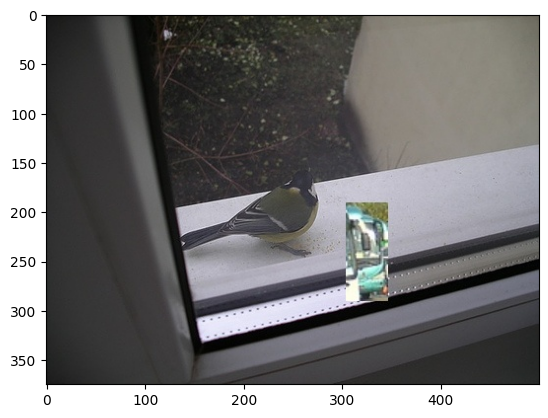

In [11]:
import matplotlib.pyplot as plt
sample = cv2.imread('./output/JPEGImages/010001.jpg')
print(sample.shape)
plt.imshow(sample[:,:,::-1])
plt.show()

## RandomHSV+RandomHorizontalFlip+RandomScale+RandomRotate+RandomShear

In [21]:
origin_path = os.path.join('.', 'output')
origin_Image_Path = os.path.join(origin_path, 'JPEGImages')
origin_Annotation_Path = os.path.join(origin_path, 'Annotations')

output_path = os.path.join('.', 'joutput')
output_Image_Path = os.path.join(output_path, 'JPEGImages')
output_Annotation_Path = os.path.join(output_path, 'Annotations_with_ID')
if not os.path.exists(output_path):
    os.mkdir(output_path)
if not os.path.exists(output_Image_Path):
    os.mkdir(output_Image_Path)
if not os.path.exists(output_Annotation_Path):
    os.mkdir(output_Annotation_Path)

In [22]:
target_list = [i.split('.')[0] for i in os.listdir(origin_Annotation_Path)[:]]

In [23]:
def gen_tree(xml_path, img_shape, bboxes):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    root.find('size/width').text = str(img_shape[0])
    root.find('size/height').text = str(img_shape[1])
    boxes = [i for i in root.iter('object')]
    for box in boxes:
        root.remove(box)
    for box in bboxes:
        new_box = ET.Element('object')
        ET.SubElement(new_box, 'ID').text = str(int(box[4]))
        bndbox = ET.SubElement(new_box, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(int(box[0]))
        ET.SubElement(bndbox, 'ymin').text = str(int(box[1]))
        ET.SubElement(bndbox, 'xmax').text = str(int(box[2]))
        ET.SubElement(bndbox, 'ymax').text = str(int(box[3]))
        root.append(new_box)
    ET.indent(root)
    return tree

In [24]:
def xml_to_boxes(path):
    tree = ET.parse(path)
    root = tree.getroot()
    list_with_all_boxes = []
    for box in root.iter('object'):
        xmin = int(box.find("bndbox/xmin").text)
        ymin = int(box.find("bndbox/ymin").text)
        xmax = int(box.find("bndbox/xmax").text)
        ymax = int(box.find("bndbox/ymax").text)
        Id = int(box.find('ID').text)
        list_with_all_boxes.append([xmin, ymin, xmax, ymax, Id])
    return np.array(list_with_all_boxes, dtype='float64')

In [25]:
def process(target):
    origin_img_path = os.path.join(origin_Image_Path, target+'.jpg')
    origin_xml_path = os.path.join(origin_Annotation_Path, target+'.xml')
    origin_boxes = xml_to_boxes(origin_xml_path)
    origin_img = cv2.imread(origin_img_path)

    output_img_path =  os.path.join(output_Image_Path, target+str(0)+'.jpg')
    output_xml_path = os.path.join(output_Annotation_Path, target+str(0)+'.xml')
    cv2.imwrite(output_img_path, origin_img)
    for i in range(1,5):
        output_img_path =  os.path.join(output_Image_Path, target+str(i)+'.jpg')
        output_xml_path = os.path.join(output_Annotation_Path, target+str(i)+'.xml')
        
        seq = Sequence([RandomHSV(40, 50, 50),RandomHorizontalFlip(), RandomScale(0.2), RandomRotate(20), RandomShear(0.2)])

        try:
            img_, bboxes_ = seq(origin_img.copy(),  origin_boxes.copy())
            cv2.imwrite(output_img_path, img_)
            tree = gen_tree(origin_xml_path, img_.shape,bboxes_)
            tree.write(output_xml_path)
        except:
            print("STOP")
    

    

In [26]:
for target in tqdm(target_list):
    process(target)

100%|██████████| 5/5 [00:00<00:00, 14.66it/s]


(375, 500, 3)


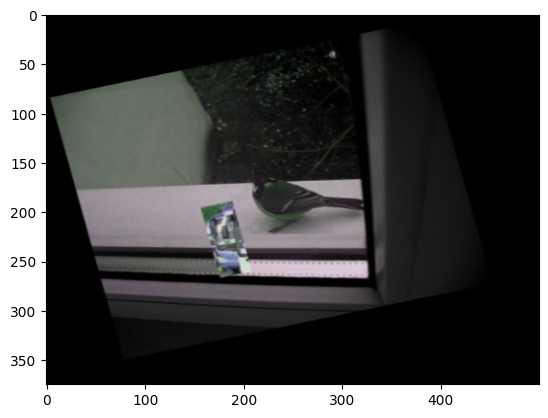

In [31]:
sample = cv2.imread('./joutput/JPEGImages/0100013.jpg')
print(sample.shape)
plt.imshow(sample[:,:,::-1])
plt.show()

## Object Detection

In [ ]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [ ]:
class_to_num = {"aeroplane":0, "bicycle":1, "bird":2, "boat":3, "bottle":4, 
                 "bus":5, "car":6, "cat":7, "chair":8, "cow":9, "diningtable":10, 
                 "dog":11, "horse":12, "motorbike":13, "person":14, "pottedplant":15, 
                 "sheep":16, "sofa":17, "train":18,"tvmonitor":19}

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


設定參數

In [ ]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './Dataset/datalab-2021-cup2-object-detection/pascal_voc_training_data.txt'
IMAGE_DIR = './Dataset/copy_paste_augmentation_2/JPEGImages/'
ANNO_PATH = './Dataset/copy_paste_augmentation_2/Annotations_with_ID/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 150

In [ ]:
import os
import xml.etree.ElementTree as ET

讀取xml檔案

In [ ]:
def read_content(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    list_with_all_boxes = []
    
    for box in root.iter('object'):
        output_box = {
            'target':root.find('filename').text.split('.')[0],
            # 'name':box.find('name').text,
            # 'pose':box.find('pose').text,
            'ID':box.find('ID').text,
            # 'truncated':box.find('truncated').text,
            # 'difficult':box.find('difficult').text,
            'xmin':int(box.find("bndbox/xmin").text),
            'ymin':int(box.find("bndbox/ymin").text),
            'xmax':int(box.find("bndbox/xmax").text),
            'ymax':int(box.find("bndbox/ymax").text)
        }
        list_with_all_boxes.append(output_box)
    return list_with_all_boxes

In [ ]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        origin = os.listdir(ANNO_PATH)
        origin.sort(key=lambda x: int(x[:-4]))
        for line in origin:
            self.image_names.append(line[:-4]+'.jpg')
            list_with_box = read_content(ANNO_PATH+line)
            list_with_record = []
            for i in range(len(list_with_box)):
                list_with_record.append(list_with_box[i]['xmin'])
                list_with_record.append(list_with_box[i]['ymin'])
                list_with_record.append(list_with_box[i]['xmax'])
                list_with_record.append(list_with_box[i]['ymax'])
                list_with_record.append(int(list_with_box[i]['ID']))
            self.record_list.append(list_with_record)
            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)
        image = tf.keras.applications.resnet.preprocess_input(image)


        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

模型建立
我們有選用resnet152,50等的模型作為feature extraction的backbone，並在訓練時freeze一定部分的layer(也有嘗試過全部都freeze起來但效果似乎不太明顯)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [ ]:
resnet_152 = tf.keras.applications.ResNet152(include_top=False, weights='imagenet',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [ ]:
resnet_152.trainable = False
for layer in resnet_152.layers[-52:]:
        layer.trainable = True

In [ ]:
# img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = resnet_152.output
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, 
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, 
                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=resnet_152.input, outputs=outputs, name="YOLO_resnet152_bakend")

建立base box以及iou 跟loss計算的function

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])
    # print(iou_predict_truth)
    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])
    # print(C)
    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [ ]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [ ]:
dataset = DatasetGenerator().generate()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [ ]:
check_name = 'yolo'
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO_self_aug_pretrain_resnet152_150', max_to_keep=3,
                                     checkpoint_name=check_name)

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)
        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import pickle

開始訓練
在過程中我們發現loss會震盪或是暴增，因此我在這邊設定讓check point要儲存有真的下降的loss，同時若loss超過一定的值之後會直接停止訓練

In [ ]:
best_loss = 1e10

In [ ]:
print("{}, start training.".format(datetime.now()))
epoch_list = []
loss_list = []

best_loss_epoch = 0
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        # print('idx is:',idx)
        train_step(image, labels, objects_num)
        # print('idx is:',idx)
    epoch_loss = train_loss_metric.result()
    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, epoch_loss))
    if i != 0 or epoch_loss<150:
        epoch_list.append(i+1)
        loss_list.append(epoch_loss)
    if best_loss>epoch_loss:
        best_loss = epoch_loss
        save_path = manager.save()
        print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path)) 
    else:
        print("skip at epoch {}".format(int(ckpt.epoch)))
    if epoch_loss> 2*1e10:
        break
fig = plt.figure(figsize=(14, 8))        
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.title('best epoch is:',best_loss_epoch,'loss is', best_loss)
plt.title('best epoch is')
plt.legend()
plt.plot(epoch_list, loss_list, color='k', label='mae')
fig.savefig("/home/norahlin/Competition/Comp_2/resnet152_YOLO_60.png", format='png')

將conv output出來的結果轉換成一個一個bounding box，我們有發現助教最開始給的code是只會output出一個box，但通過觀察測試集的圖片發現其實會有一張圖有多個box的狀況發生，因此我們有設定一個threshold讓同樣也很高的bbox能一起被呈現出來，同時再用Non_max_suppression的algo來將重複框選的bbox刪除，但或許是我們model太過簡單，因此即使用了這個方法雖然有稍微提升一點，但最終結果依舊不慎理想

In [ ]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [ ]:
PROB_THRES = 0.05
IOU_THRES = 0.3

In [ ]:
def multiple_process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, 20))
    scales = np.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
    predicts = np.concatenate([class_probs, scales, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                              CELL_SIZE,
                              BOXES_PER_CELL, 
                              4))

    output = []
    
    counter = np.sum(P>PROB_THRES)
    if counter == 0:
        counter = 1

    while counter>0:
        max_conf = np.max(P)
        index = np.argmax(P)
        index = np.unravel_index(index, P.shape)
        assert P[index] == max_conf, "not match"

        P[index[0],index[1],index[2],:] = 0.
        class_num = index[3]

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h

        counter = np.sum(P>PROB_THRES)
        output.append([xmin, ymin, xmax, ymax, class_num, max_conf])

    return output

loading test data

In [ ]:
test_img_files = open('/home/norahlin/Competition/Comp_2/Dataset/datalab-2021-cup2-object-detection/pascal_voc_testing_data.txt')
test_img_dir = '/home/norahlin/Competition/Comp_2/Dataset/datalab-2021-cup2-object-detection/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1
    image = tf.keras.applications.resnet.preprocess_input(image)
    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO_self_aug_pretrain_resnet152_150/yolo-9')

In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

@tf.function
def tf_non_max(boxes,scores,max_value):
    return tf.image.non_max_suppression(boxes,
                                        scores,
                                        max_value,
                                        iou_threshold=IOU_THRES)

In [ ]:
output_file = open('./test_prediction.txtt','w')
for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        temp = multiple_process_outputs(prediction_step(test_img[i:i+1]))

        now_w = img_w[i:i+1].numpy().tolist()[0]
        now_h = img_h[i:i+1].numpy().tolist()[0]

        box_np = np.zeros((len(temp),4))
        class_num_list = []
        conf_list = []

        for j in range(len(temp)):
            pred = temp[j]
            xmin, ymin, xmax, ymax, class_num, conf = pred[0], pred[1], pred[2], pred[3], pred[4], pred[5]

            xmin = max(xmin, 0)
            ymin = max(ymin, 0)
            xmax = min(xmax, IMAGE_SIZE)
            ymax = min(ymax, IMAGE_SIZE)

            box_np[j,:] = [xmin*(now_w/IMAGE_SIZE), ymin*(now_h/IMAGE_SIZE), xmax*(now_w/IMAGE_SIZE), ymax*(now_h/IMAGE_SIZE)]
            class_num_list.append(class_num)
            conf_list.append(conf)

        if len(conf_list)==1:
            output_box, output_conf, output_class = box_np.tolist(), conf_list, class_num_list
        else:
            output_box, output_conf, output_class = cal_non_max(box_np, class_num_list, conf_list)

        assert len(output_box)==len(output_conf)==len(output_class), "got difference length"
        
        # start output
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))
        for k in range(len(output_class)):
            # for every box
            now_box = output_box[k]
            output_file.write(" %d %d %d %d %d %f" % (now_box[0], now_box[1], now_box[2],now_box[3], output_class[k], output_conf[k]))
            
        output_file.write("\n")

output_file.close()

In [ ]:
import sys
sys.path.insert(0, './evaluate')

In [ ]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_augmentation_pretrain_150.csv')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

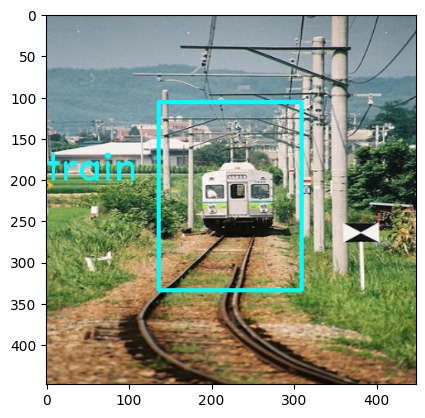

In [ ]:
np_img = cv2.imread(
    '/home/norahlin/Competition/Comp_2/Dataset/datalab-2021-cup2-object-detection/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
temp = multiple_process_outputs(y_pred)
for j in range(len(temp)):
    pred = temp[j]
    xmin, ymin, xmax, ymax, class_num, conf = pred[0], pred[1], pred[2], pred[3], pred[4], pred[5]
    # print(xmin,ymin, xmax,ymax)
    class_name = classes_name[class_num]
    cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
    cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()


## Summarize
#### 1. Augumentation
我們運用助教提示的copy-paste的方法來增加某些sample較少的類別，在這邊選用以原資料類別機率分布的方式挑選要貼上的類別圖片(原資料中類別較少的object會越容易被選擇)，以此來讓我們的訓練集可以平衡的看到各個類別，同時也在做完copy-paste後對圖片進行翻轉和位移等處理讓我們的data從原本的五千多張擴增到上萬張。
#### 2. Model
model的部份我們原先都是使用助教提供的model以及嘗試更換一些feature extraction的backbone，但結果卻不盡理想，在找原因的過程中我們比較多著重在dataset、training loss的設定、以及Inference的問題，卻沒有發現改進model的架構才是重點，當最後發現問題時，已經來不及重新手刻不同的model了，我們認為這是我們這次失敗的主要原因，我們下次比賽會記取本次的教訓，要更宏觀的來觀察整個任務的最重要的部分，並在發現結果不對時盡快做出修正。
